### Second Notebook: Data Cleaning & Preprocessing (Sprint 1 - Continued)

In [228]:
# Imports and Setup
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

data_path = os.path.join(os.getcwd(), '..', 'data')
out_path = os.path.join(os.getcwd(), '..', 'outputs')     # For the output

# Read the files
train = pd.read_csv(os.path.join(data_path, 'train.csv'))
test = pd.read_csv(os.path.join(data_path, 'test.csv'))
labels = pd.read_csv(os.path.join(data_path, 'train_labels.csv'))

# Merge training labels
df = pd.merge(train, labels, on='id')
print('Files successfully loaded and merged!')


Files successfully loaded and merged!


### ---------------------------------------------
### 🚧 Step 1: Handle Missing & Invalid Values
### ---------------------------------------------

In [229]:
# Replace 0s with NaN where 0 means "missing" or invalid

df['construction_year'] = df['construction_year'].replace(0, np.nan)
df['gps_height'] = df['gps_height'].replace([0, -90], np.nan)
df['longitude'] = df['longitude'].replace(0, np.nan)
print("Missing values after cleaning invalid numeric entries:")
print(df[['construction_year', 'gps_height', 'longitude']].isnull().sum())
missing_before = df['construction_year'].isna().sum()
# Save original missing count

print("Missing construction_year before:", missing_before)

Missing values after cleaning invalid numeric entries:
construction_year    20709
gps_height           20439
longitude             1812
dtype: int64
Missing construction_year before: 20709


### ---------------------------------------------
### 🔧 Step 2: Construction Year Imputation
### ---------------------------------------------

In [230]:
# Save original missing count

print("Missing before:", missing_before)
# Pumps in the same region likely have similar construction years
# Same funder or installer may follow same timeline
# Fill missing years with the median by region + installer
# If construction_year is missing, we could use date_recorded.year as an upper bound for imputation.
df['date_recorded'] = pd.to_datetime(df['date_recorded'])
df['recorded_year'] = df['date_recorded'].dt.year



Missing before: 20709


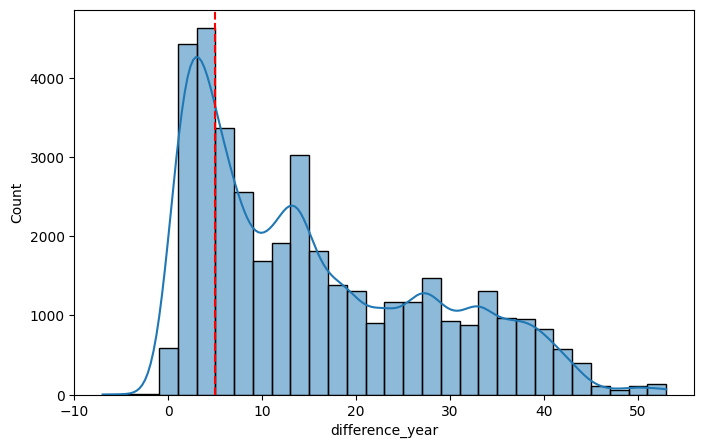

In [231]:
#visualize the relationship between construction_year and date_recorded to see how they are related
valid_years = df[df['construction_year'].notna()].copy()
valid_years['difference_year'] = valid_years['recorded_year']-valid_years['construction_year']

plt.figure(figsize=(8, 5))
sns.histplot(valid_years['difference_year'], bins=30, kde=True)
plt.axvline(5, color='red', linestyle='--', label='5-Year Gap')
plt.show()


In [232]:
#Impute using region + installer
df['construction_year'] = df.groupby(['region', 'installer'])['construction_year'].transform(
    lambda x: x.fillna(x.median())
)
#Impute using region only (for rows still missing)
df['construction_year'] = df.groupby('region')['construction_year'].transform(
    lambda x: x.fillna(x.median())
)
#Use recorded year - 5
df['construction_year'] = df['construction_year'].fillna(df['recorded_year'] - 5)
missing_after = df['construction_year'].isna().sum()
print("Missing after_construction_year:", missing_after)
filled_count = missing_before - missing_after
print("Filled_construction_year:", filled_count)
df.to_csv(os.path.join(out_path, "cleaned_data_filled.csv"), index=False)
print(df['longitude'].describe())
print("lMissing values in latitude and longitude:",df[['latitude', 'longitude']].isnull().sum())


Missing after_construction_year: 0
Filled_construction_year: 20709
count    57588.000000
mean        35.149669
std          2.607428
min         29.607122
25%         33.285100
50%         35.005943
75%         37.233712
max         40.345193
Name: longitude, dtype: float64
lMissing values in latitude and longitude: latitude        0
longitude    1812
dtype: int64


### ---------------------------------------------
### 🌍 Step 3: Fill Coordinates and Elevation
### ---------------------------------------------

In [233]:
# Handle GPS coordinates
print(df['longitude'].describe())
print("latitudeb and longitude missing value before:", df[['latitude', 'longitude']].isnull().sum())

# Convert to numeric in case of weird types
df['latitude'] = pd.to_numeric(df['latitude'], errors='coerce')
df['longitude'] = pd.to_numeric(df['longitude'], errors='coerce')

# Drop invalid latitudes: outside Tanzania range or near zero
df['latitude'] = df['latitude'].apply(lambda x: np.nan if pd.isna(x) or abs(x) < 0.1 or x < -15 or x > 0 else x)
df['longitude'] = df['longitude'].apply(lambda x: np.nan if pd.isna(x) or abs(x) < 10 or x < 29 or x > 42 else x)

# Drop rows where lat/lon still missing
df = df.dropna(subset=['latitude', 'longitude'])
print("Remaining rows after dropping invalid GPS data:", len(df))

# Save updated version
df.to_csv(os.path.join(out_path,"cleaned_data_filled_V2.csv"), index=False)
print("Cleaned data saved to data/cleaned_data_filled_V2.csv")



count    57588.000000
mean        35.149669
std          2.607428
min         29.607122
25%         33.285100
50%         35.005943
75%         37.233712
max         40.345193
Name: longitude, dtype: float64
latitudeb and longitude missing value before: latitude        0
longitude    1812
dtype: int64
Remaining rows after dropping invalid GPS data: 57588
Cleaned data saved to data/cleaned_data_filled_V2.csv


In [234]:
## filling missing values for gps_height
# # Replace invalid gps_height values (e.g. 0 or negative)
df['gps_height'] = df['gps_height'].apply(lambda x: np.nan if x <= 0 else x)

missing_gps_before = df['gps_height'].isna().sum()
print("Missing before gps_height:", missing_gps_before)

# Fill using median per basin
df['gps_height'] = df.groupby('basin')['gps_height'].transform(
    lambda x: x.fillna(x.median())
)
# Fill any still missing using region median
df['gps_height'] = df.groupby('region')['gps_height'].transform(
    lambda x: x.fillna(x.median())
)    
missing_gps_after = df['gps_height'].isna().sum()
print("Missing after gps_height:", missing_gps_after)
print("Filled gps_height:", missing_gps_before - missing_gps_after)
df.to_csv(os.path.join(out_path, "cleaned_data_filled_V3.csv"), index=False)
print("Saved updated dataset to data/cleaned_data_filled_V3.csv")



Missing before gps_height: 20122
Missing after gps_height: 0
Filled gps_height: 20122
Saved updated dataset to data/cleaned_data_filled_V3.csv


### ---------------------------------------------
### 👥 Step 4: Population Cleaning
### ---------------------------------------------

Missing population before: 19569


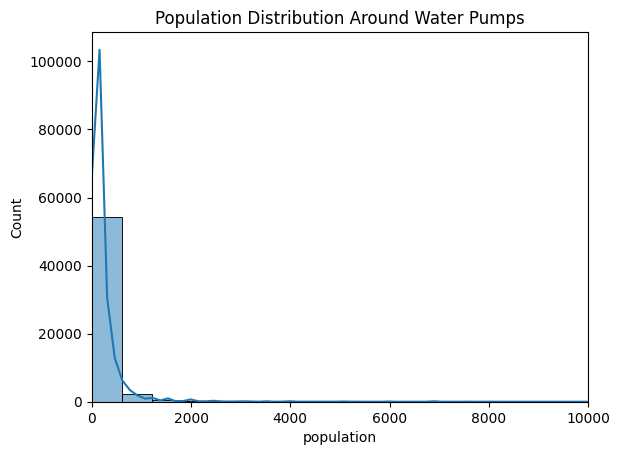

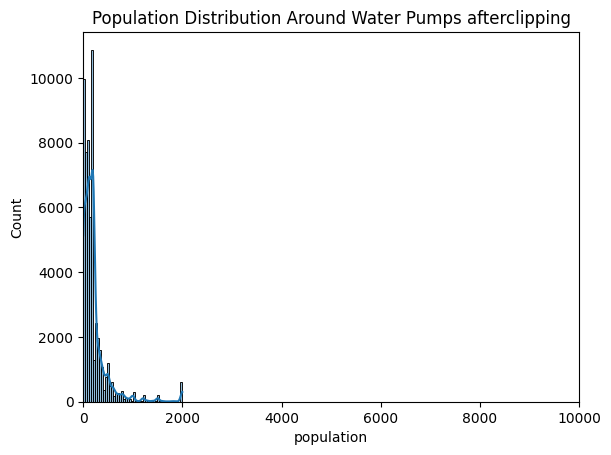

In [235]:
# filling population
# Replace 0 with NaN
df['population'] = df['population'].replace(0, np.nan)
missing_pop_before = df['population'].isna().sum()

print("Missing population before:", missing_pop_before)

# Fill using median by district_code
df['population'] = df.groupby('district_code')['population'].transform(
    lambda x: x.fillna(x.median())
)
# Fill any still missing with median by region
df['population'] = df.groupby('region')['population'].transform(
    lambda x: x.fillna(x.median())
)

df.to_csv(os.path.join(out_path, "cleaned_data_filled_V4.csv"), index=False)

sns.histplot(df['population'], bins=50, kde=True)
plt.xlim(0, 10000)  # Focus on lower range
plt.title("Population Distribution Around Water Pumps")
#plt.savefig("outputs/population_distribution_before_clipping.png", dpi=300, bbox_inches='tight')
plt.show()
df['population'] = df['population'].clip(upper=1999)
sns.histplot(df['population'], bins=50, kde=True)
plt.xlim(0, 10000)  # Focus on lower range
plt.title("Population Distribution Around Water Pumps afterclipping")
#plt.savefig("outputs/population_distribution_after_clipping.png", dpi=300, bbox_inches='tight')
df.to_csv(os.path.join(out_path, "cleaned_data_filled_V5.csv"))
plt.show()

### ---------------------------------------------
### Encode Categorical Variables
### ---------------------------------------------

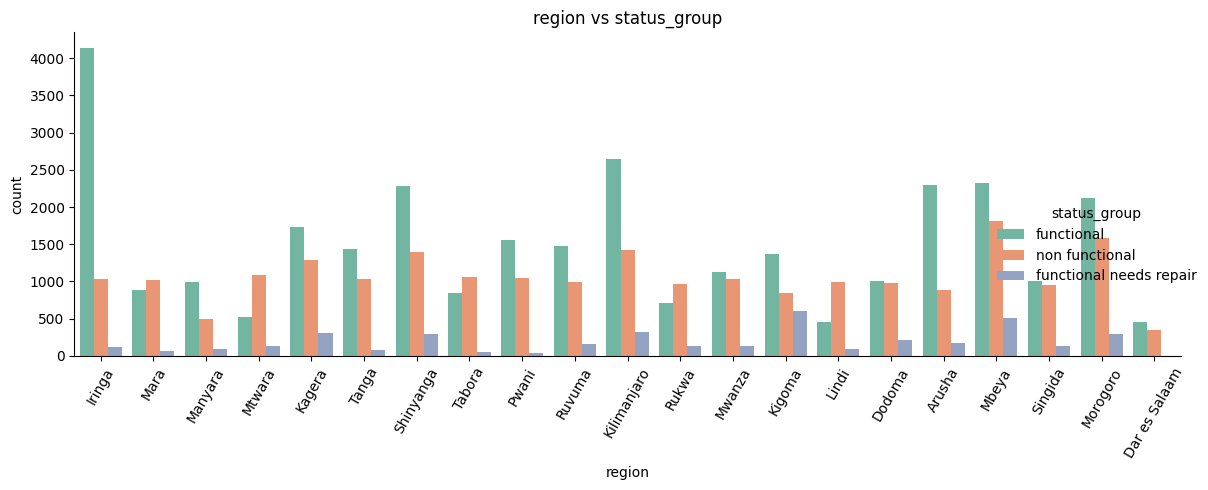

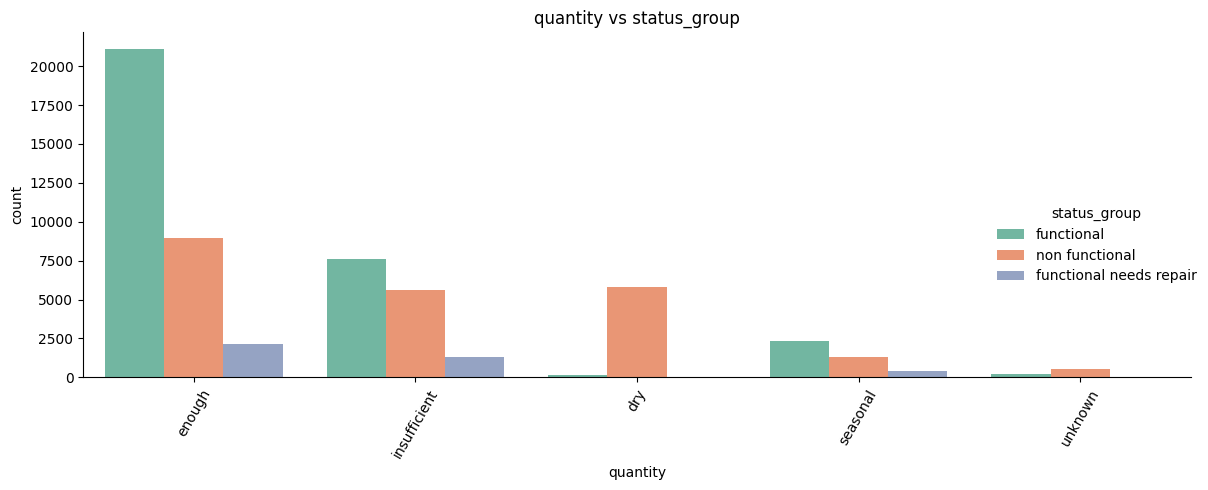

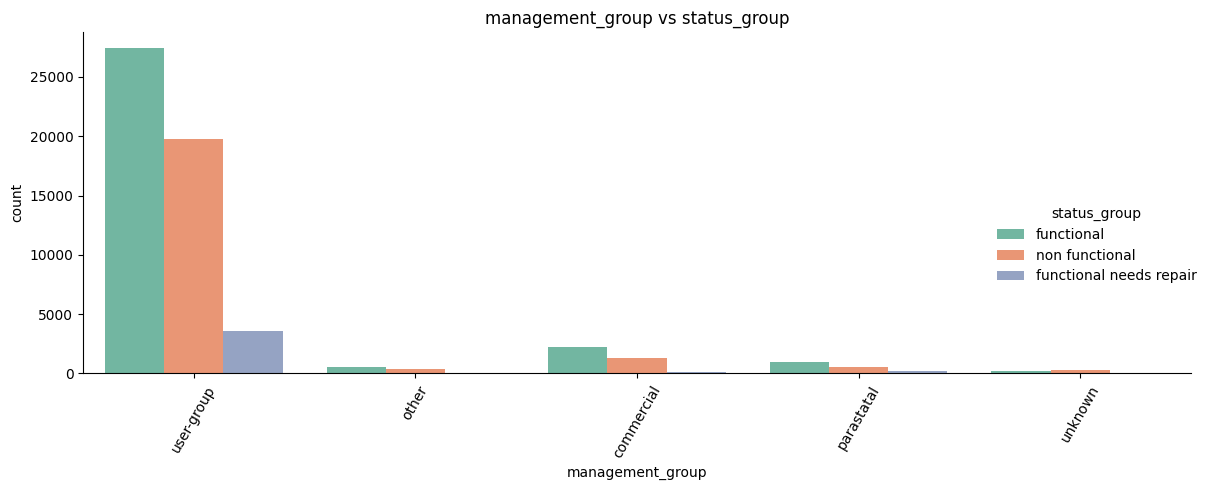

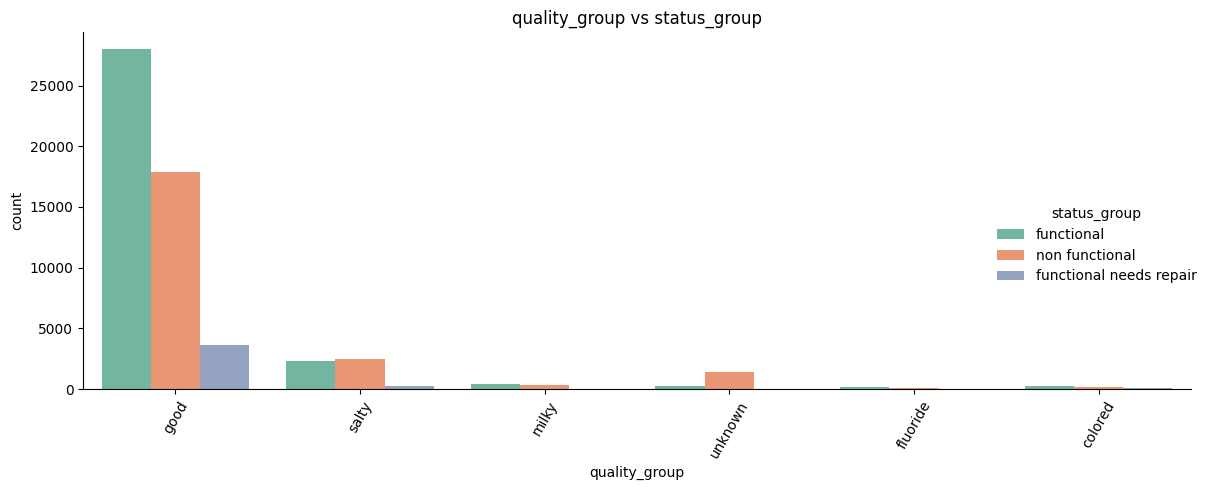

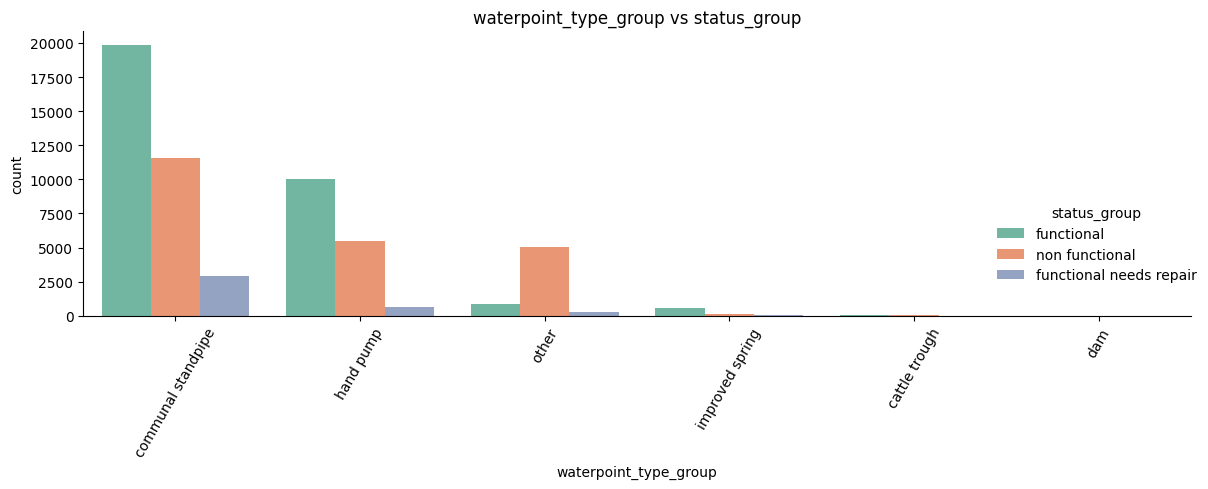

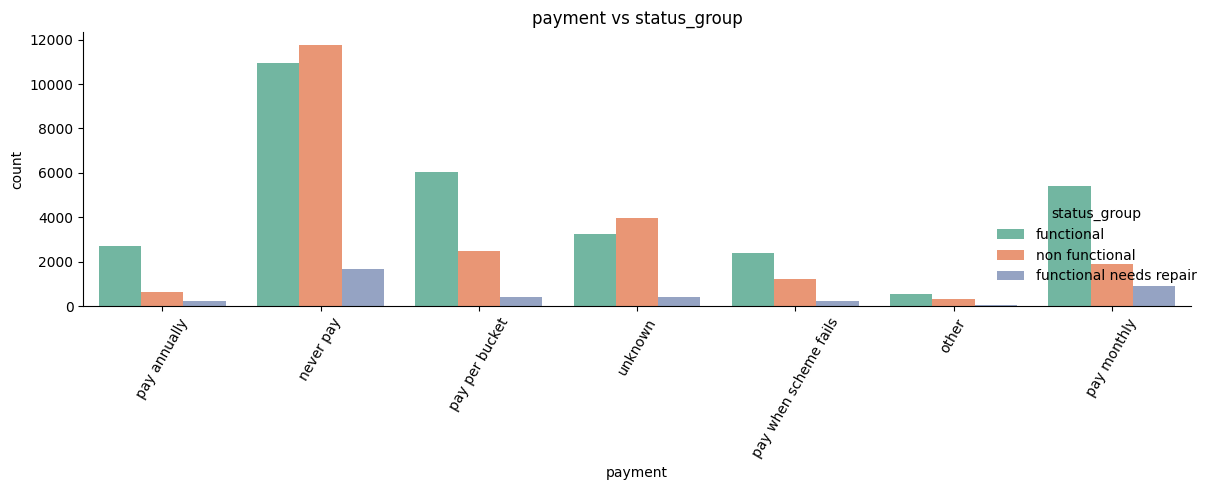

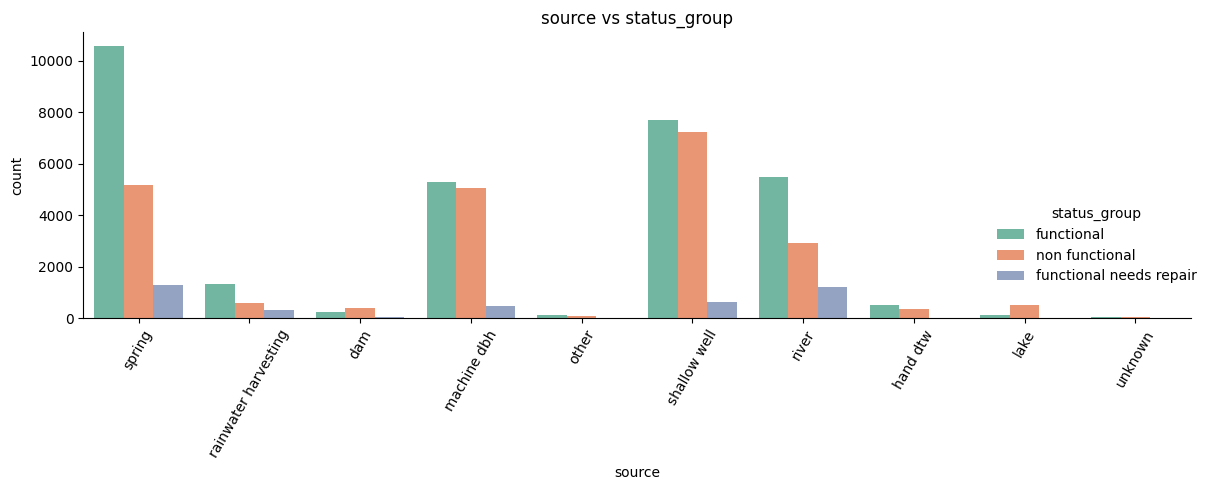

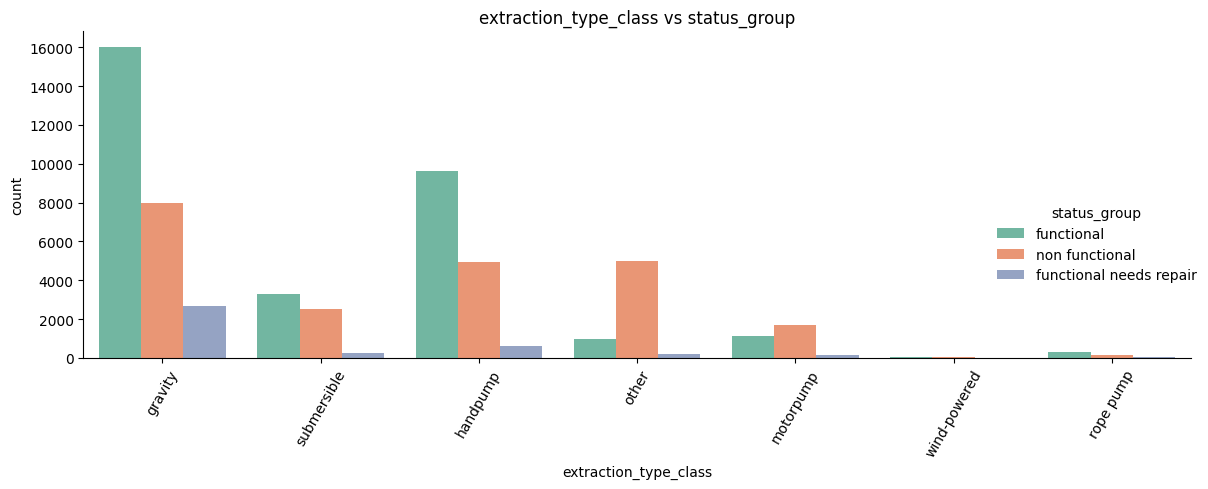

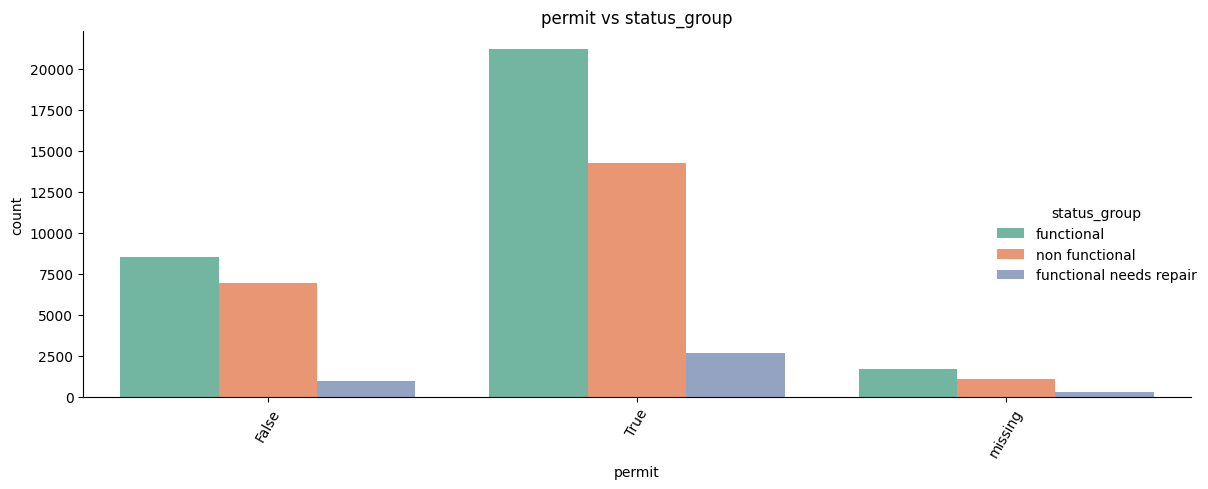

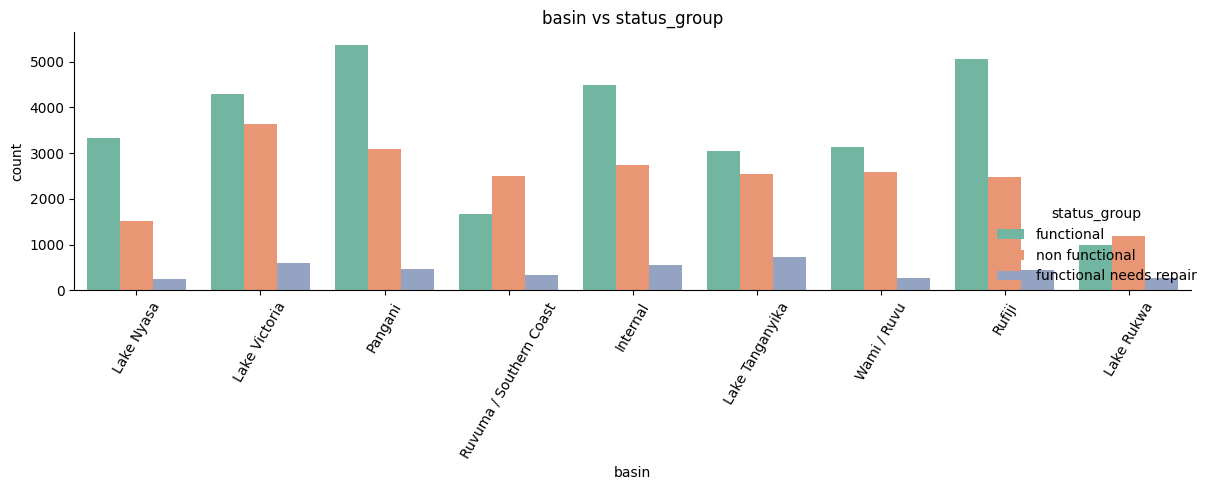

In [236]:
from sklearn.preprocessing import LabelEncoder

# Load cleaned data
path = os.path.join(os.getcwd(), '..', 'data')
df = pd.read_csv(os.path.join(path, 'cleaned_data_filled_V5.csv'))

# Fill missing categorical values with 'missing'
df = df.fillna('missing')

# Categorical variable 
catvars = [
    'region','quantity','management_group','quality_group',
    'waterpoint_type_group','payment','source',
    'extraction_type_class','permit','basin'
]

# Plot grouped bar plots colored by pump status
target = 'status_group'
for col in catvars:
    sns.catplot(x=col, kind='count', hue=target, data=df, height=5, aspect=2, palette='Set2')
    plt.xticks(rotation=60)
    plt.title(f"{col} vs {target}")
    plt.tight_layout()
    plt.show()


### Encoding for modeling prep

In [237]:

# Drop high-cardinality categorical columns
drop_cols = ['funder', 'installer', 'wpt_name', 'subvillage', 'scheme_name']
categorical_cols = df.select_dtypes(include='object').columns.tolist()
categorical_cols = [col for col in categorical_cols if col not in drop_cols and col != 'id' and col != target]


# One-hot encode medium-cardinality features
onehot_cols = [col for col in categorical_cols if 10 < df[col].nunique() <= 10]
df_encoded = pd.get_dummies(df, columns=onehot_cols, drop_first=True)

# Label encode low-cardinality categorical features
label_enc_cols = [col for col in categorical_cols if df[col].nunique() <= 20]
label_encoders = {}
for col in label_enc_cols:
    le = LabelEncoder()
    df[col] = df[col].astype(str)  # Convert to string for safety
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le


# Save encoded dataset
os.makedirs(path, exist_ok=True)
df_encoded.to_csv(os.path.join(path, 'encoded_data_V1.csv'), index=False)

print("Categorical EDA and encoding complete.")

Categorical EDA and encoding complete.


In [249]:
# Load data
y = pd.read_csv(os.path.join(path, 'train_labels.csv'))
x_full = pd.read_csv(os.path.join(path, 'cleaned_data_filled_V5.csv'))
x_full = x_full.drop(columns=['status_group'], errors='ignore')

# Drop status_group if present
x_full = x_full.drop(columns=['status_group'], errors='ignore')
df = pd.merge(y, x_full, on='id', how='inner')

# Prepare inputs
x = df[['amount_tsh', 'gps_height', 'population', 'construction_year', 'num_private']].copy()

# Normalize
x['construction_year'] = (x['construction_year'] - x['construction_year'].mean()) / x['construction_year'].std()
y = df['status_group'].astype('category').cat.codes

# Shape check
print("X shape:", x.shape)
print("Y shape:", y.shape)



X shape: (57588, 5)
Y shape: (57588,)


In [251]:
import statsmodels.api as sm
x = sm.add_constant(x)
model = sm.OLS(y,x)
results = model.fit()
print(results.summary2())

                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.050      
Dependent Variable: y                AIC:                154821.3769
Date:               2025-04-21 13:43 BIC:                154875.1433
No. Observations:   57588            Log-Likelihood:     -77405.    
Df Model:           5                F-statistic:        610.6      
Df Residuals:       57582            Prob (F-statistic): 0.00       
R-squared:          0.050            Scale:              0.86110    
--------------------------------------------------------------------
                     Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
--------------------------------------------------------------------
const                1.0652   0.0098 108.4995 0.0000  1.0459  1.0844
amount_tsh          -0.0000   0.0000 -13.6666 0.0000 -0.0000 -0.0000
gps_height          -0.0002   0.0000 -23.8850 0.0000 -0.0002 -0.0002
population          -0.0001   0.0000  -7.0411 0.0000 

We see that the basic regression considers all the quantitative variables statistically significant, but not having such a large effect, with the exception of construction year. This suggests that the analysis will rely on 